In [1]:
# libraries
from math import *
import math
import cv2
import traceback
import os
import time
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
from keras.models import Sequential
from keras import optimizers
from keras.layers.convolutional import Cropping2D
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Lambda
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label

### model prediction ###
# 0: VEHICLE
# 1: NON-VEHICLE
########################

Using TensorFlow backend.


In [31]:
# setting random seed
np.random.seed(77)

# paths
test_images_path = "./../test_images/"
test_images_output_path = "./../test_images_output/"
test_videos_path = "./../test_videos/project_video.mp4"
test_videos_output_path = "./../test_videos_output/"
vehicle_images_path = "./../data/vehicles/vehicles/"
non_vehicle_images_path = "./../data/non-vehicles/non-vehicles/"
scaler_object_path = "./../trained_models/scaler_model/scaler_object.pkl"
trained_rf_model_path = "./../trained_models/random_forest/rf_model.pkl"
trained_svm_model_path = "./../trained_models/svm/svm_model.pkl"
trained_cnn_model_path = "./../trained_models/cnn/cnn.ckpt"
plots_path = "./../plots/"

# global variables
input_shape = (64, 64, 3)
batch_size = 100
learning_rate = 0.2
epochs = 50
len_train_X = 0
len_val_X = 0
orientation = 8
pixels_per_cell = 8
cells_per_block = 2
spatial_size = (16, 16)
histogram_nbins = 32
rectangle_pt1 = (525, 370)
rectangle_pt2 = (1280, 660)
window_size = (64, 64)
window_overlapping = (0.85, 0.85)
train_image_size = (64, 64)
heatmap_threshold = 5
heat_prev = np.zeros((720, 1280)) # to store previous heatmap
prev_heat_count = 0

In [3]:
# function for reading image
def read_image(image_path):
	# reading image and converting from BGR to RGB
	img = cv2.imread(image_path)
	img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
	return img

In [4]:
# function for showing image
def show_image(img, title=None):
	plt.imshow(img)
	if(title != None):
		plt.title(title)
	plt.show()

In [5]:
# function for drawing rectangle on image
def draw_rectangle(img, top_left_corner, bottom_right_corner):
	# drawing rectangle
	cv2.rectangle(img, top_left_corner, bottom_right_corner, (0,0,255), 2)
	return img

In [6]:
# function for preparing train data
def get_data(path):
	# for collecting path of all images
	all_images_path = []
	# getting list of subdirs
	subdir_list = os.listdir(path)
	# traversing through each subdirectory
	for i in range(len(subdir_list)):
		# getting list of files
		files = os.listdir(path + subdir_list[i] + "/")
		# traversing through each file
		for j in range(len(files)):
			# path of current file
			file_path = path + subdir_list[i] + "/" + files[j]
			# appending file_path
			all_images_path.append(file_path)
	return all_images_path


In [7]:
# function for getting hog features
def get_hog_features(img):
	global orientation, pixels_per_cell, cells_per_block
	# getting hog-features
	features = hog(img, orientations=orientation,
				pixels_per_cell=(pixels_per_cell, pixels_per_cell),
				cells_per_block=(cells_per_block, cells_per_block), 
				transform_sqrt=True, visualise=False, feature_vector=True)
	return features

In [8]:
# function for getting spatial features
def get_spatial_features(img):
	global spatial_size
	return cv2.resize(img, spatial_size).ravel()

In [9]:
# function for getting color histogram features
def get_histogram_features(img):
	global histogram_nbins
	channel_1 = np.histogram(img[:,:,0], bins=histogram_nbins, range=(0, 256))[0]
	channel_2 = np.histogram(img[:,:,1], bins=histogram_nbins, range=(0, 256))[0]
	channel_3 = np.histogram(img[:,:,2], bins=histogram_nbins, range=(0, 256))[0]
	histogram = np.hstack((channel_1, channel_2, channel_3))
	return histogram

In [10]:
# function for reading all images, generating and returning all images
def get_all_features_labels(path_list):
	# variable for storing features
	feature_set = []
	labels = []
	# traversing through all paths in path1
	for i in range(len(path_list)):
		# reading image
		img = read_image(path_list[i])
		# flipping image (data augmentation)
		flipped_img = cv2.flip(img, 1)
		# generating features for original image
		img_hog_features = get_hog_features(cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0])
		img_spatial_features = get_spatial_features(img)
		img_hist_features = get_histogram_features(img)
		img_features = np.hstack((img_hog_features, img_spatial_features, img_hist_features))
		# generating features for flipped image
		flipped_img_hog_features = get_hog_features(flipped_img[:,:,0])
		flipped_img_spatial_features = get_spatial_features(flipped_img)
		flipped_img_hist_features = get_histogram_features(flipped_img)
		flipped_img_features = np.hstack((flipped_img_hog_features, flipped_img_spatial_features, flipped_img_hist_features))
		# appending features into main list
		feature_set.append(img_features)
		feature_set.append(flipped_img_features)
		# making label
		if(path_list[i].split("/")[3] == "vehicles"):
			labels.append(0)
			labels.append(0)
		elif(path_list[i].split("/")[3] == "non-vehicles"):
			labels.append(1)
			labels.append(1)
		else:
			print("Error in get_all_features_labels")
			break
	return np.array(feature_set), np.array(labels)

In [11]:
def sliding_window_positions():
	global rectangle_pt1, rectangle_pt2, window_size, window_overlapping
	# calculating length of region of interest
	len_x_roi = rectangle_pt2[0] - rectangle_pt1[0]
	len_y_roi = rectangle_pt2[1] - rectangle_pt1[1]
	# calculating number of pixels by which window slides
	x_inc = np.int(window_size[0] * (1 - window_overlapping[0]))
	y_inc = np.int(window_size[1] * (1 - window_overlapping[1]))
	# calculating number of windows along x-axis
	x_overlap = np.int(window_size[0] * window_overlapping[0])
	no_x_windows = np.int((len_x_roi - x_overlap) / x_inc)
	# calculating number of windows along y-axis
	y_overlap = np.int(window_size[1] * window_overlapping[1])
	no_y_windows = np.int((len_y_roi - y_overlap) / y_inc)
	# list variable for storing position of windows
	windows = []
	# loop through finding x and y window positions
	for y_window in range(no_y_windows):
		for x_window in range(no_x_windows):
			# calculating window position
			x_start = x_window * x_inc + rectangle_pt1[0]
			x_end = x_start + window_size[0]
			y_start = y_window * y_inc + rectangle_pt1[1]
			y_end = y_start + window_size[1]
			# appdinding positions in list
			windows.append(((x_start, y_start), (x_end, y_end)))
	# return the list of windows
	return windows

In [12]:
# function for drawing windows on images
def draw_windows(img, windows):
	# iterating through windows
	for i in range(len(windows)):
		# drawing rectangle on image
		img = draw_rectangle(img, windows[i][0], windows[i][1])
	return img

In [13]:
# function for finding windows probably having car
def find_windows_having_car(img, windows, scaler, model):
	global train_image_size
	# for listing windows probably having car
	car_windows = []
	# iterating windows
	for i in range(len(windows)):
		# extracting window
		image_patch = img[windows[i][0][1]:windows[i][1][1], windows[i][0][0]:windows[i][1][0], :]
		# resizing image_patch to train_image_size
		image_patch = cv2.resize(image_patch, train_image_size)
		# if scaler is not-none, using randomForest or SVM
		if(scaler != None):
			# genrating features
			hog_features = get_hog_features(image_patch[:,:,0])
			spatial_features = get_spatial_features(image_patch)
			hist_features = get_histogram_features(image_patch)
			features = np.hstack((hog_features, spatial_features, hist_features))
			# normalizing features
			features = scaler.transform(features)
			# getting prediction: car or non-car
			pred = model.predict(features)
			# if car is present 
			if(pred == 0):
				car_windows.append(windows[i])
		# else using SVM
		else:
			# reshaping image matrix
			image_patch = np.reshape(image_patch, (1, train_image_size[0], train_image_size[1], 3))
			pred = model.predict(image_patch, batch_size=1)
			pred = np.argmax(pred, 1)
			if(pred == 0):
				car_windows.append(windows[i])
	return car_windows

In [14]:
# function for adding heat in heatmap image
def add_heat(heatmap, bbox_list):
	# Iterate through list of bboxes
	for box in bbox_list:
		# Add += 1 for all pixels inside each bbox
		# Assuming each "box" takes the form ((x1, y1), (x2, y2))
		heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
	# Return updated heatmap
	return heatmap

In [15]:
# function for applying threshold on heat image
def apply_threshold(heatmap, threshold):
	# Zero out pixels below the threshold
	heatmap[heatmap <= threshold] = 0
	# Return thresholded map
	return heatmap

In [16]:
# function for marking cars
def draw_labeled_bboxes(img, labels):
	# Iterate through all detected cars
	for car_number in range(1, labels[1]+1):
		# Find pixels with each car_number label value
		nonzero = (labels[0] == car_number).nonzero()
		# Identify x and y values of those pixels
		nonzeroy = np.array(nonzero[0])
		nonzerox = np.array(nonzero[1])
		# Define a bounding box based on min/max x and y
		bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
		# Draw the box on the image
		cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
	# Return the image
	return img

In [17]:
# function for loading pretrained CNN model
def load_cnn():
	input_shape = (64, 64, 3)
	learning_rate = 0.2
	# cnn model
	model = Sequential()
	model.add(Lambda(lambda x:x/255.0, input_shape=input_shape))
	model.add(Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
	model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
	model.add(MaxPooling2D(pool_size=(2,2)))
	model.add(Flatten())
	model.add(Dense(64, activation='relu'))
	model.add(Dropout(0.25))
	model.add(Dense(2))
	# CNN optimizer
	optimizer = optimizers.Adadelta(lr=learning_rate)
	# compiling model
	model.compile(loss="binary_crossentropy", optimizer=optimizer)
	# load model
	model.load_weights(cnn_model_path)
	return model

In [18]:
# function for reading image pixels and making labels
def read_images_make_labels(images_path_list):
	# variable for storing all images and labels
	images_list = []
	labels_list = []
	# iterating through each image
	for i in range(len(images_path_list)):
		# reading image
		img = read_image(images_path_list[i])
		# appending image
		images_list.append(img)
		# making label
		if(images_path_list[i].split("/")[3] == "vehicles"):
			labels_list.append(0)
		elif(images_path_list[i].split("/")[3] == "non-vehicles"):
			labels_list.append(1)
		else:
			print("Error: labels not found")
	return np.array(images_list), np.array(labels_list)

In [19]:
# generator function for training
def train_generator():
	try:
		# global variables
		global batch_size, input_shape, train_X, train_Y, len_train_X
		# getting length of train data
		len_train_X = len(train_X)
		# converting labels into one-hot vector
		train_Y = np.array(pd.get_dummies(pd.Series(train_Y)))
		# runing generator
		while(True):
			for index in range(int(math.ceil(len_train_X/batch_size))):
				# making batches of size batch_size
				current_image_bucket = train_X[index * int(batch_size) : (index + 1) * int(batch_size), :, :, :]
				current_label_bucket = train_Y[index * int(batch_size) : (index + 1) * int(batch_size), :]
				yield current_image_bucket, current_label_bucket
	except Exception as e:
		traceback.print_exc()

In [20]:
# generator function for validation
def val_generator():
	try:
		# global variables
		global batch_size, input_shape, val_X, val_Y, len_val_X
		# getting length of validation data
		len_val_X = len(val_X)
		# converting labels into one-hot vector
		val_Y = np.array(pd.get_dummies(pd.Series(val_Y)))
		# runing generator
		while(True):
			for index in range(int(math.ceil(len_val_X/batch_size))):
				# making batch of data
				current_image_bucket = val_X[index * int(batch_size) : (index + 1) * int(batch_size), :, :, :]
				current_label_bucket = val_Y[index * int(batch_size) : (index + 1) * int(batch_size), :]
				yield current_image_bucket, current_label_bucket
	except Exception as e:
		traceback.print_exc()

In [21]:
# function for processing video/test-images
def rf_pipeline(img):
	global windows, scaler, rf_model, heatmap_threshold, heat_prev, prev_heat_count
	# finding windows probably having car
	car_windows = find_windows_having_car(img, windows, scaler, rf_model)
	# heatmap image
	heat = np.zeros_like(img[:,:,0]).astype(np.float)
	# add heat to each window in windows list
	heat = add_heat(heat, car_windows)
	# multiframe accumulated heatmap
	heat_out = heat_prev + heat
	prev_heat_count += 1
	if(prev_heat_count >= 8):
		heat_prev = heat
		prev_heat_count = 0
	# apply threshold to help remove false positives
	heat = apply_threshold(heat_out, heatmap_threshold)
	# clipping all values in heatmap
	heatmap = np.clip(heat, 0, 255)
	# find final boxes from heatmap using label function
	labels = label(heatmap)
	# drawing car_windows on image and showing image
	draw_img = draw_labeled_bboxes(np.copy(img), labels)
	return draw_img

In [22]:
# function for processing video/test-images
def svm_pipeline(img):
	global windows, scaler, svm_model, heatmap_threshold, heat_prev, prev_heat_count
	# finding windows probably having car
	car_windows = find_windows_having_car(img, windows, scaler, svm_model)
	# heatmap image
	heat = np.zeros_like(img[:,:,0]).astype(np.float)
	# add heat to each window in windows list
	heat = add_heat(heat, car_windows)
	# multiframe accumulated heatmap
	heat_out = heat_prev + heat
	prev_heat_count += 1
	if(prev_heat_count >= 8):
		heat_prev = heat
		prev_heat_count = 0
	# apply threshold to help remove false positives
	heat = apply_threshold(heat_out, heatmap_threshold)
	# clipping all values in heatmap
	heatmap = np.clip(heat, 0, 255)
	# find final boxes from heatmap using label function
	labels = label(heatmap)
	# drawing car_windows on image and showing image
	draw_img = draw_labeled_bboxes(np.copy(img), labels)
	return draw_img

In [23]:
# function for processing video/test-images
def cnn_pipeline(img):
	global windows, cnn_model, heatmap_threshold, heat_prev, prev_heat_count
	# finding windows probably having car
	car_windows = find_windows_having_car(img, windows, None, cnn_model)
	# heatmap image
	heat = np.zeros_like(img[:,:,0]).astype(np.float)
	# add heat to each window in windows list
	heat = add_heat(heat, car_windows)
	# multiframe accumulated heatmap
	heat_out = heat_prev + heat
	prev_heat_count += 1
	if(prev_heat_count >= 8):
		heat_prev = heat
		prev_heat_count = 0
	# apply threshold to help remove false positives
	heat = apply_threshold(heat_out, heatmap_threshold)
	# clipping all values in heatmap
	heatmap = np.clip(heat, 0, 255)
	# find final boxes from heatmap using label function
	labels = label(heatmap)
	# drawing car_windows on image and showing image
	draw_img = draw_labeled_bboxes(np.copy(img), labels)
	return draw_img

In [24]:
# getting path of all vehicle and non-vehicle images
vehicle_images_path_list = get_data(vehicle_images_path)
non_vehicle_images_path_list = get_data(non_vehicle_images_path)
images_list = np.array(vehicle_images_path_list + non_vehicle_images_path_list)

In [25]:
# getting features and labels
features, labels = get_all_features_labels(images_list)

In [26]:
# preprocessing features
scaler = StandardScaler()
scaler.fit(features)
features = scaler.transform(features)

In [27]:
# saving scaler object
joblib.dump(scaler, scaler_object_path)

['./../trained_models/scaler_model/scaler_object.pkl']

In [28]:
# updating status
print("Features Shape: " + str(features.shape))
print("Labels Shape: " + str(len(labels)))

Features Shape: (35520, 2432)
Labels Shape: 35520


In [29]:
# object for 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, random_state=77)

In [30]:
# 10-fold cross-validation
fold = 1
rf_accuracies_list = []
svm_accuracies_list = []
rf_kappa_list = []
svm_kappa_list = []
for train_index, val_index in skf.split(features, labels):
	# dividing data into train and validation set
	train_X, val_X = features[train_index], features[val_index]
	train_Y, val_Y = labels[train_index], labels[val_index]
	# getting models
	rf_model = RandomForestClassifier()
	svm_model = LinearSVC(loss='hinge')
	# training model
	rf_model.fit(train_X, train_Y)
	svm_model.fit(train_X, train_Y)
	# validating model
	rf_pred = rf_model.predict(val_X)
	svm_pred = svm_model.predict(val_X)
	# getting accuracy and kappa
	rf_accuracy = accuracy_score(rf_pred, val_Y) * 100
	svm_accuracy = accuracy_score(svm_pred, val_Y) * 100
	rf_kappa = cohen_kappa_score(rf_pred, val_Y) * 100
	svm_kappa = cohen_kappa_score(svm_pred, val_Y) * 100
	# updating status
	print(str(fold) + ". RF Accuracy: " + str(rf_accuracy) + "\tRF Kappa: " + str(rf_kappa))
	print(str(fold) + ". SVM Accuracy: " + str(svm_accuracy) + "\tSVM Kappa: " + str(svm_kappa))
	fold = fold + 1
	# storing results
	rf_accuracies_list.append(rf_accuracy)
	svm_accuracies_list.append(svm_accuracy)
	rf_kappa_list.append(rf_kappa)
	svm_kappa_list.append(svm_kappa)

1. RF Accuracy: 95.5530537574	RF Kappa: 91.1019876107
1. SVM Accuracy: 98.0579791725	SVM Kappa: 96.1147842067
2. RF Accuracy: 95.524908528	RF Kappa: 91.0437333148
2. SVM Accuracy: 98.3675766958	SVM Kappa: 96.7345468006
3. RF Accuracy: 97.213622291	RF Kappa: 94.4258691321
3. SVM Accuracy: 98.6208837602	SVM Kappa: 97.2415763245
4. RF Accuracy: 98.3957219251	RF Kappa: 96.7917907508
4. SVM Accuracy: 98.9304812834	SVM Kappa: 97.8607787036
5. RF Accuracy: 98.6204954955	RF Kappa: 97.2410697132
5. SVM Accuracy: 98.6486486486	SVM Kappa: 97.296834511
6. RF Accuracy: 98.7612612613	RF Kappa: 97.5226638972
6. SVM Accuracy: 98.8738738739	SVM Kappa: 97.7476449193
7. RF Accuracy: 98.1695297099	RF Kappa: 96.3399026331
7. SVM Accuracy: 98.4511405238	SVM Kappa: 96.9023756252
8. RF Accuracy: 97.7752745705	RF Kappa: 95.5516233469
8. SVM Accuracy: 98.7045902563	SVM Kappa: 97.4092739953
9. RF Accuracy: 98.394818361	RF Kappa: 96.789984209
9. SVM Accuracy: 98.9862010701	SVM Kappa: 97.9723402311
10. RF Accuracy

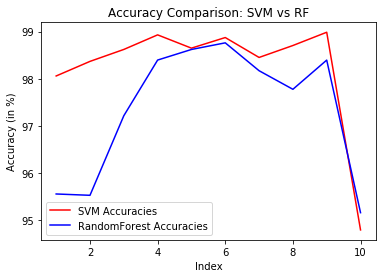

In [32]:
# plotting accuracies of svm and rf
svm_acc_line, = plt.plot(range(1, len(svm_accuracies_list) + 1), svm_accuracies_list, 'r')
rf_acc_line, = plt.plot(range(1, len(rf_accuracies_list) + 1), rf_accuracies_list, 'b')
plt.title("Accuracy Comparison: SVM vs RF")
plt.xlabel("Index")
plt.ylabel("Accuracy (in %)")
plt.legend([svm_acc_line, rf_acc_line], ['SVM Accuracies', 'RandomForest Accuracies'])
plt.savefig(plots_path + "svm_rf_accuracy_comparison.png")
plt.show()

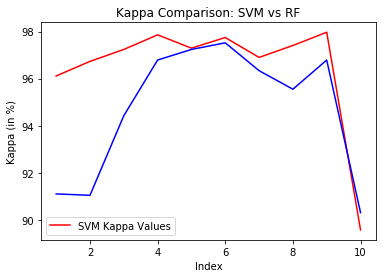

In [33]:
# plotting kappa of svm and rf
svm_kappa_line, = plt.plot(range(1, len(svm_kappa_list) + 1), svm_kappa_list, 'r')
rf_kappa_line = plt.plot(range(1, len(rf_kappa_list) + 1), rf_kappa_list, 'b')
plt.title("Kappa Comparison: SVM vs RF")
plt.xlabel("Index")
plt.ylabel("Kappa (in %)")
plt.legend([svm_kappa_line, rf_kappa_line], ['SVM Kappa Values', 'RandomForest Kappa Values'])
plt.savefig(plots_path + "svm_rf_kappa_comparison.png")
plt.show()

In [34]:
# getting models
rf_model = RandomForestClassifier()
svm_model = LinearSVC(loss='hinge')

In [35]:
# training models on entire data
rf_model.fit(features, labels)
svm_model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [36]:
# saving model
joblib.dump(rf_model, trained_rf_model_path)
joblib.dump(svm_model, trained_svm_model_path)

['./../trained_models/svm/svm_model.pkl']

In [37]:
# getting all images and labels
images, labels = read_images_make_labels(images_list)

In [38]:
# training and validation data for CNN
train_X, val_X, train_Y, val_Y = train_test_split(images, labels, test_size=0.1, stratify=labels, random_state=77)
len_train_X = len(train_X)
len_val_X = len(val_X)
print("Train data: " + str(train_X.shape) + "\t" + str(train_Y.shape))
print("Val data: " + str(val_X.shape) + "\t" + str(val_Y.shape))

Train data: (15984, 64, 64, 3)	(15984,)
Val data: (1776, 64, 64, 3)	(1776,)


In [39]:
# cnn model
cnn_model = Sequential()
cnn_model.add(Lambda(lambda x:x/255.0, input_shape=input_shape))
cnn_model.add(Conv2D(filters=16, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
cnn_model.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.25))
cnn_model.add(Dense(2))

In [40]:
# CNN optimizer
optimizer = optimizers.Adadelta(lr=learning_rate)

In [41]:
# compiling model
cnn_model.compile(loss="binary_crossentropy", optimizer=optimizer)

In [42]:
# training CNN model and saving it
cnn_model.fit_generator(train_generator(), epochs=epochs, steps_per_epoch=int(math.ceil(len_train_X/float(batch_size))), max_queue_size=batch_size, verbose=1)
cnn_model.save(trained_cnn_model_path)

Epoch 1/50
160/160 [==============================] - 54s - loss: 0.5722    
Epoch 2/50
160/160 [==============================] - 52s - loss: 0.3196    
Epoch 3/50
160/160 [==============================] - 53s - loss: 0.2518    
Epoch 4/50
160/160 [==============================] - 55s - loss: 0.2210    
Epoch 5/50
160/160 [==============================] - 56s - loss: 0.1828    
Epoch 6/50
160/160 [==============================] - 55s - loss: 0.1537    
Epoch 7/50
160/160 [==============================] - 55s - loss: 0.1510    
Epoch 8/50
160/160 [==============================] - 54s - loss: 0.1354    
Epoch 9/50
160/160 [==============================] - 55s - loss: 0.1299    
Epoch 10/50
160/160 [==============================] - 55s - loss: 0.1146    
Epoch 11/50
160/160 [==============================] - 56s - loss: 0.1071    
Epoch 12/50
160/160 [==============================] - 56s - loss: 0.0992    
Epoch 13/50
160/160 [==============================] - 57s - loss: 0.0815

In [43]:
# getting list of windows (sliding window)
windows = sliding_window_positions()

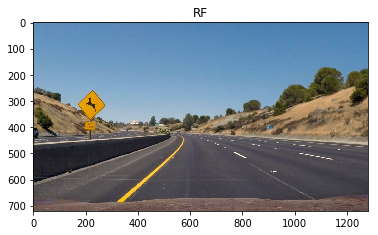

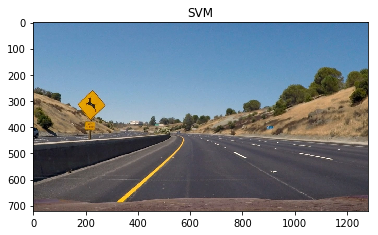

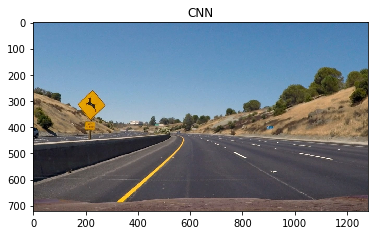

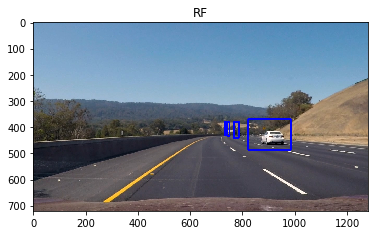

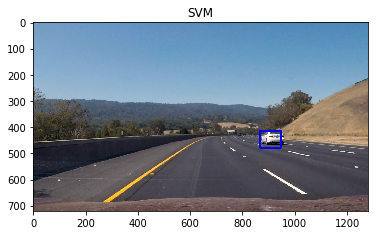

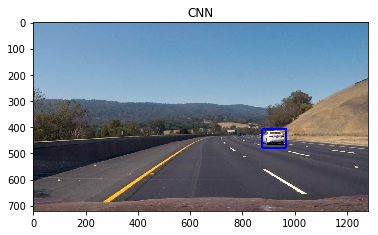

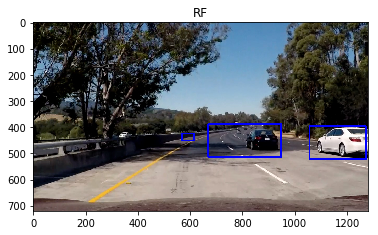

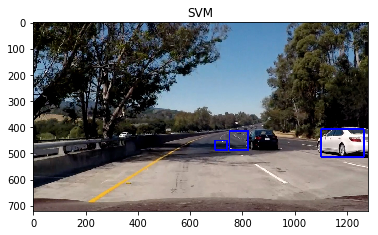

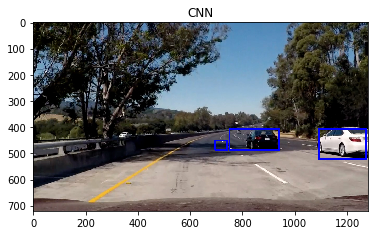

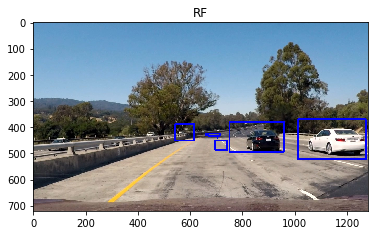

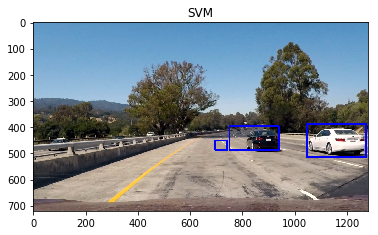

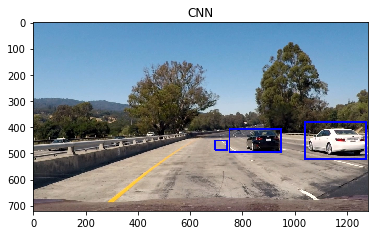

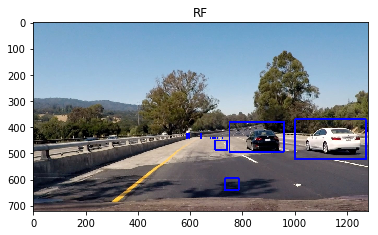

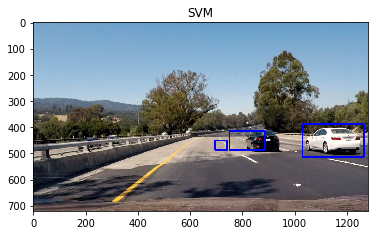

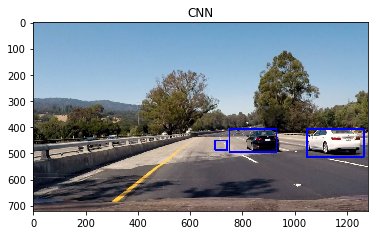

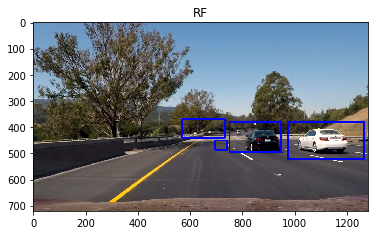

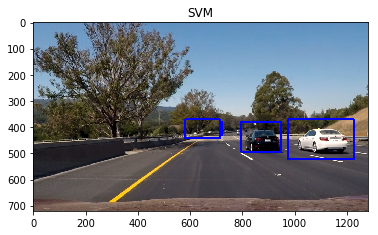

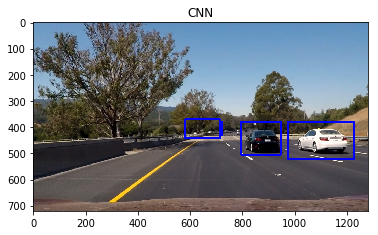

In [44]:
# processing all test images
test_files = os.listdir(test_images_path)
for i in range(len(test_files)):
	start_time = time.time()
	# reading test image
	img = read_image(test_images_path + test_files[i])
	# getting output
	rf_output = rf_pipeline(img)
	svm_output = svm_pipeline(img)
	cnn_output = cnn_pipeline(img)
	# showing images
	show_image(rf_output, title="RF")
	show_image(svm_output, title="SVM")
	show_image(cnn_output, title="CNN")
	# changing color space of images
	rf_img = cv2.cvtColor(rf_output, cv2.COLOR_BGR2RGB)
	svm_img = cv2.cvtColor(svm_output, cv2.COLOR_BGR2RGB)
	cnn_img = cv2.cvtColor(cnn_output, cv2.COLOR_BGR2RGB)
	# saving images
	cv2.imwrite(test_images_output_path + "rf_" + test_files[i], rf_img)
	cv2.imwrite(test_images_output_path + "svm_" + test_files[i], svm_img)
	cv2.imwrite(test_images_output_path + "cnn_" + test_files[i], cnn_img)

In [45]:
# processing project video by randomForest
video_input1 = VideoFileClip(test_videos_path)
processed_video = video_input1.fl_image(rf_pipeline)
processed_video.write_videofile(test_videos_output_path + "rf_output.mp4", audio=False)

[MoviePy] >>>> Building video ./../test_videos_output/rf_output.mp4
[MoviePy] Writing video ./../test_videos_output/rf_output.mp4


100%|█████████▉| 1260/1261 [3:12:03<00:09,  9.17s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./../test_videos_output/rf_output.mp4 



In [46]:
# processing project video by SVM
video_input1 = VideoFileClip(test_videos_path)
processed_video = video_input1.fl_image(svm_pipeline)
processed_video.write_videofile(test_videos_output_path + "svm_output.mp4", audio=False)

[MoviePy] >>>> Building video ./../test_videos_output/svm_output.mp4
[MoviePy] Writing video ./../test_videos_output/svm_output.mp4


100%|█████████▉| 1260/1261 [46:13<00:02,  2.20s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./../test_videos_output/svm_output.mp4 



In [47]:
# processing project video by CNN
video_input1 = VideoFileClip(test_videos_path)
processed_video = video_input1.fl_image(cnn_pipeline)
processed_video.write_videofile(test_videos_output_path + "cnn_output.mp4", audio=False)

[MoviePy] >>>> Building video ./../test_videos_output/cnn_output.mp4
[MoviePy] Writing video ./../test_videos_output/cnn_output.mp4


100%|█████████▉| 1260/1261 [1:30:19<00:04,  4.29s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./../test_videos_output/cnn_output.mp4 

